# Position filtering with gaussian convolution

**Best is gaussian_std = 7h**
- too low  -> inertial oscillation
- too high -> loose the real position of the trajectory in the curvatures. 

#### Imports

In [1]:
import sys
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import xarray as xr

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
import Drifters_processing
import utils_plots

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/drifters_scenes'
path_save_plots = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-07-05_FilteringDrifters'

In [2]:
# L3 field data
path_fields = '../save_data/fields_data'
ds_swot = add_Tgrid_velocities(xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc')))

# SVP Drifters
drifters_directory = '../save_data/drifters'
FILES_SVP

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

## One trajectory processing

two interesting traj (move around the swath, inertial oscillations...)

FILES_SVP=3, idx_id=5

FILES_SVP=3, idx_id=18

In [3]:
one_trajectory = open_one_traj(drifters_directory, FILES_SVP[3], idx_id= 18, L3_cleaning=True, padd_swath=0.75)
one_trajectory

<xarray.Dataset>
Dimensions:  (time: 3893)
Coordinates:
    id       <U15 '300534062470440'
  * time     (time) datetime64[ns] 2023-03-31T17:00:00 ... 2023-07-09
    dt       float64 1.8e+03
Data variables:
    u        (time) float64 0.3207 0.3234 0.3279 ... -0.03271 -0.02475 -0.009841
    v        (time) float64 0.2303 0.2129 0.1973 0.1753 ... 0.1122 0.1068 0.1055
    lon      (time) float64 4.887 4.894 4.902 4.909 ... 5.0 5.0 4.999 4.999
    lat      (time) float64 42.27 42.27 42.27 42.27 ... 42.54 42.54 42.54 42.54
Attributes:
    traj_id:  file=L2_svp_shom_10min_lowess_30min_v0.nc ; idx_id=18

In [17]:
# apply gaussian filter on positions

GAUSSIAN_STD = 7 #hours

liss_lat = Drifters_processing.gaussian_filter(one_trajectory.lat, dt=one_trajectory.dt, gaussian_std=GAUSSIAN_STD*3600)
liss_lon = Drifters_processing.gaussian_filter(one_trajectory.lon, dt=one_trajectory.dt, gaussian_std=GAUSSIAN_STD*3600)

/tmp/ipykernel_36823/818363713.py:36: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


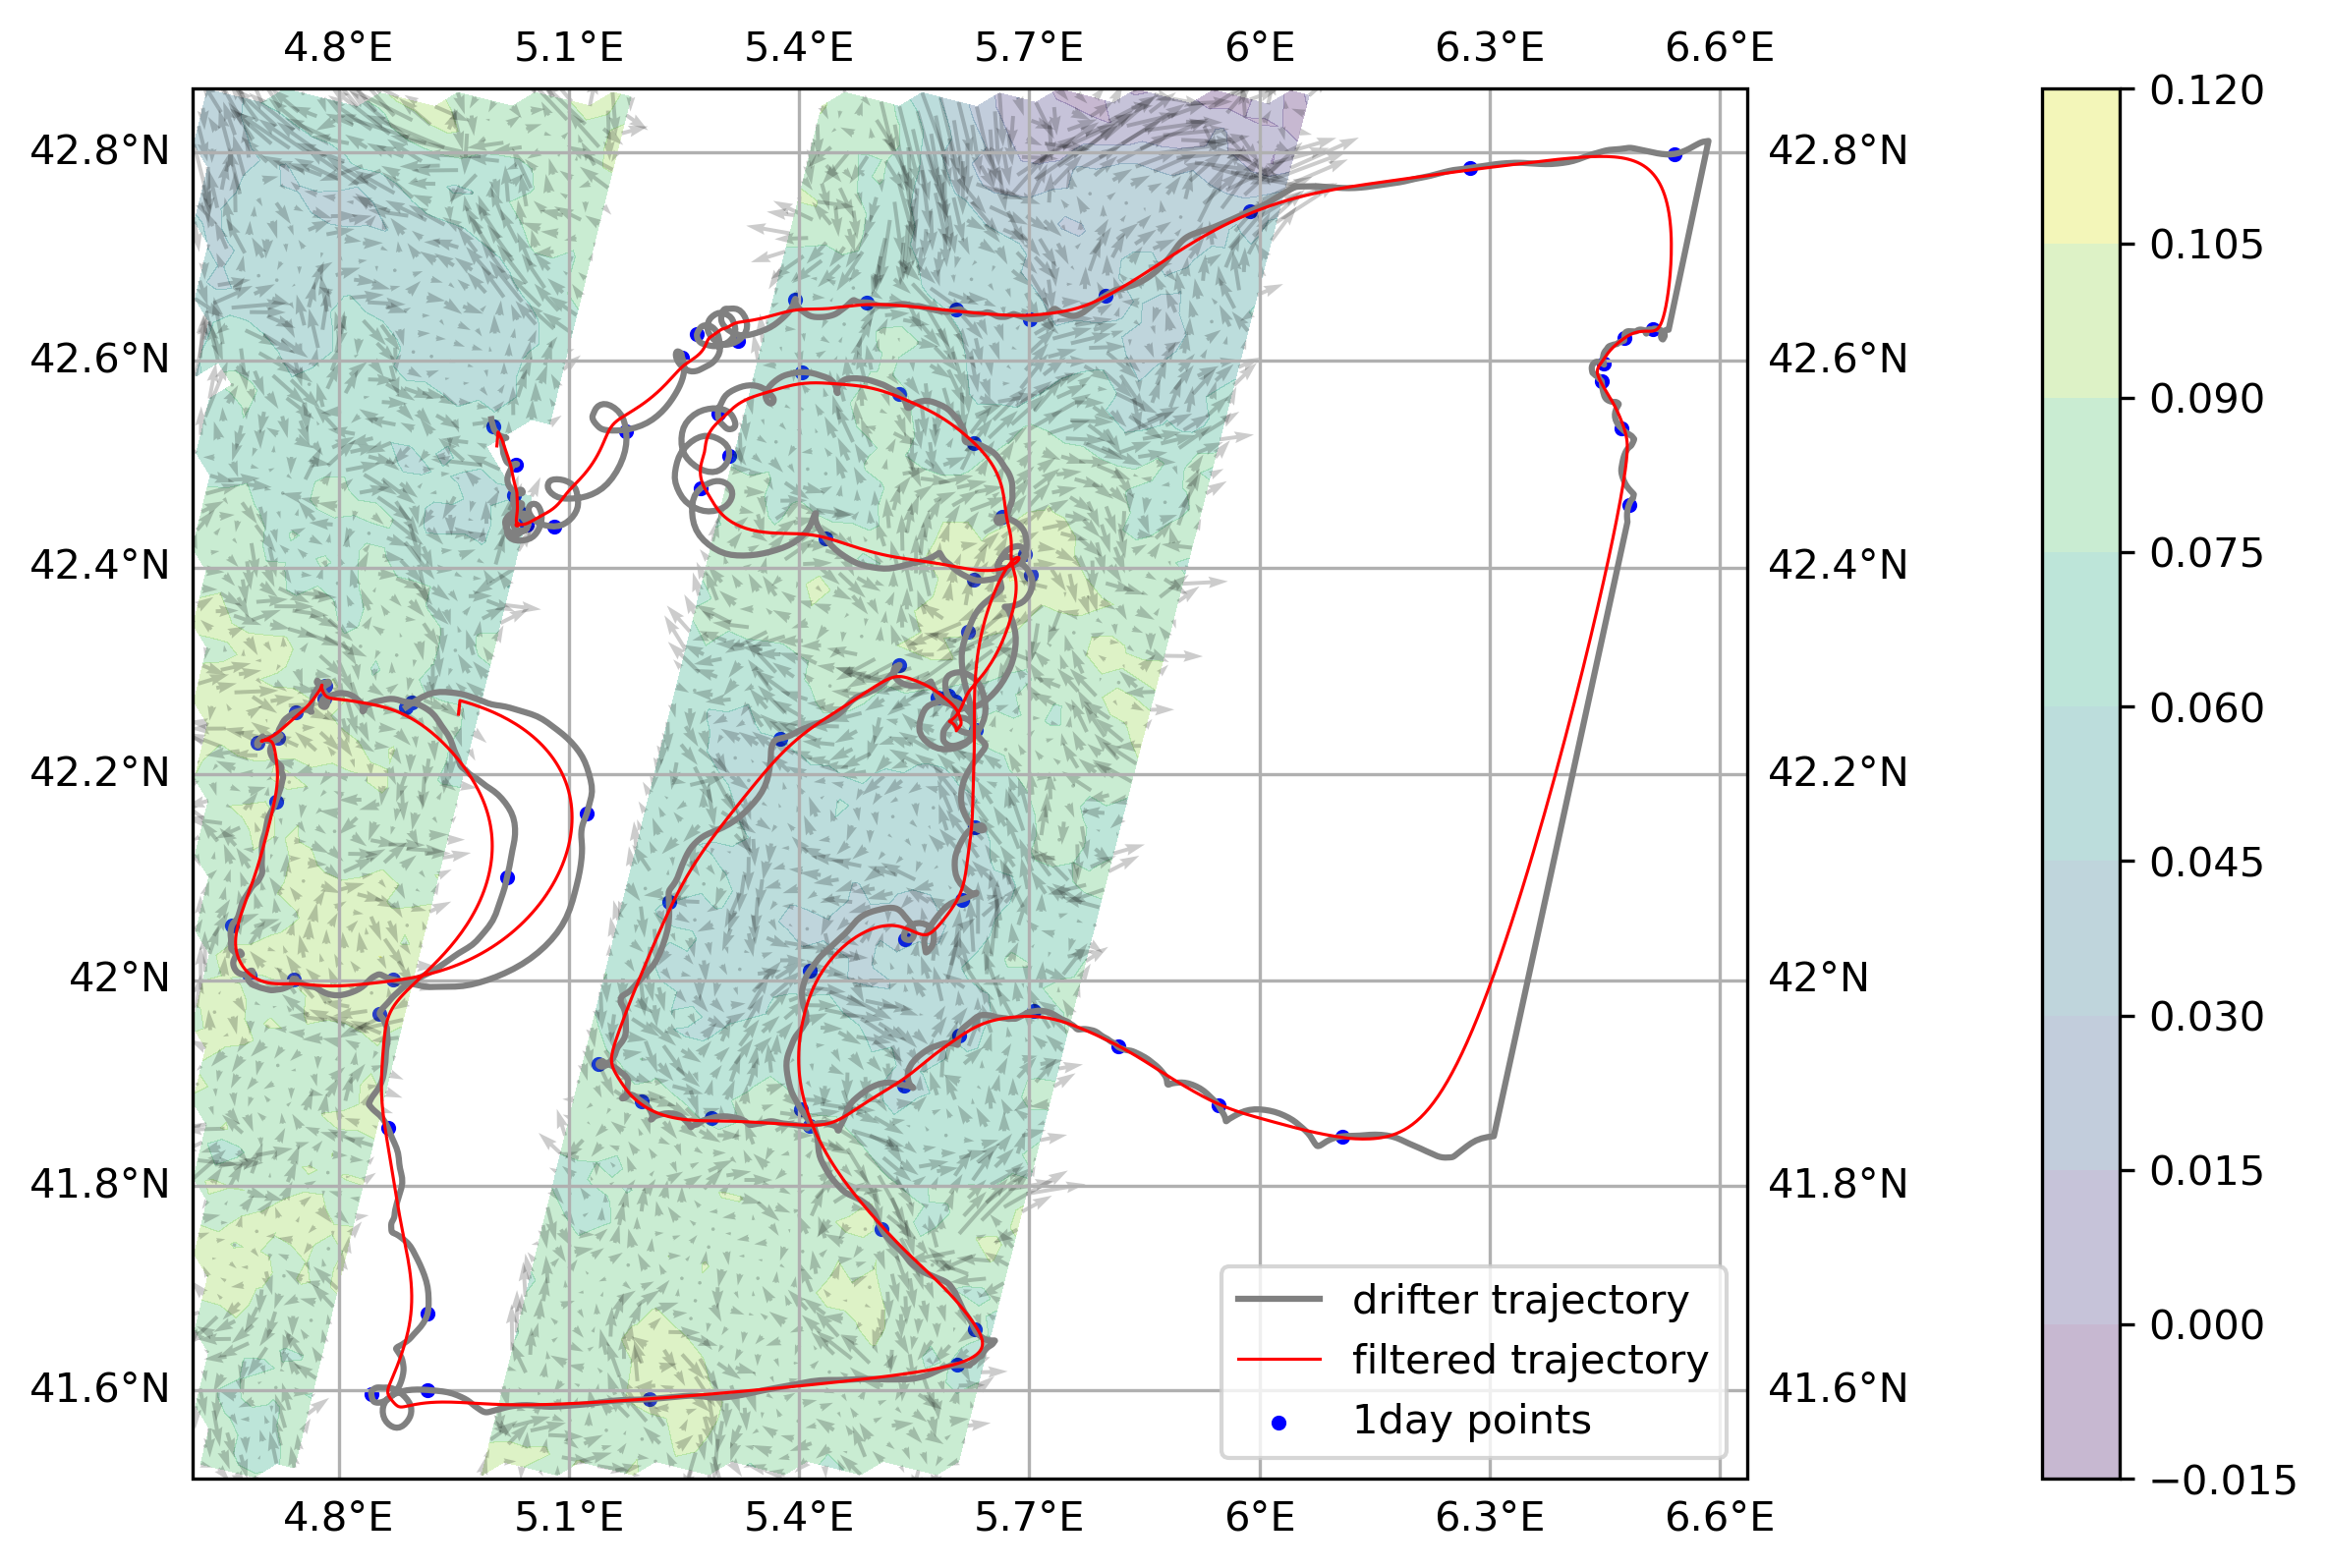

In [23]:

ds = one_trajectory

matplotlib.rcParams['figure.dpi'] = 300

plt.ion()

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)
scale=3e-5 *2
width=2.5e-3

padd = 0.05
bbox = (np.nanmin(ds.lon.values) -padd, np.nanmax(ds.lon.values) +padd, np.nanmin(ds.lat.values)-padd, np.nanmax(ds.lat.values)+padd ) 
ax.set_extent(bbox, crs=crs)

# trajectory
ax.plot(ds.lon, ds.lat,transform=crs, color='grey', label='drifter trajectory')

# filtered
ax.plot(liss_lon, liss_lat, transform=crs, color='red', lw=0.75, label='filtered trajectory')

#points day
points_day = (ds.lon[::48], ds.lat[::48])
ax.scatter(*points_day, transform=crs, color='b', s=7, label='1day points')


# ssh field
#time_ssh = get_mean_datetime(ds.time.values)
#time_ssh = np.nanmin(ds.time.values)
time_ssh = get_mean_datetime(ds.time.values)

field = restrain_domain(ds_swot, *bbox)
field = field.interp(time=time_ssh)
ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.3, label='SSH (swot)')

# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
cbar = plt.colorbar(ssh_field, cax=cax)

# add velocity field
ax.quiver(field.longitude.values, field.latitude.values, field.u_var.values, field.v_var.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)
#ax.quiver(field.longitude.values, field.latitude.values, field.u_geos.values, field.v_geos.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)

ax.legend()

plt.savefig(os.path.join(path_save_plots, 'filtreddrifter_gaussian_{}h.png'.format(GAUSSIAN_STD)), bbox_inches='tight', dpi = 300)

### filter analysis

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


filtering at 19h: 0.004972934739385385
filtering at 24h: 0.033929909313514
filtering at 36h: 0.22756373406943625
filtering at 48h: 0.44144928739421746
filtering at 72h: 0.6938233754632097
filtering at 96h: 0.834124587100774
filtering at 120h: 0.8719039215993687


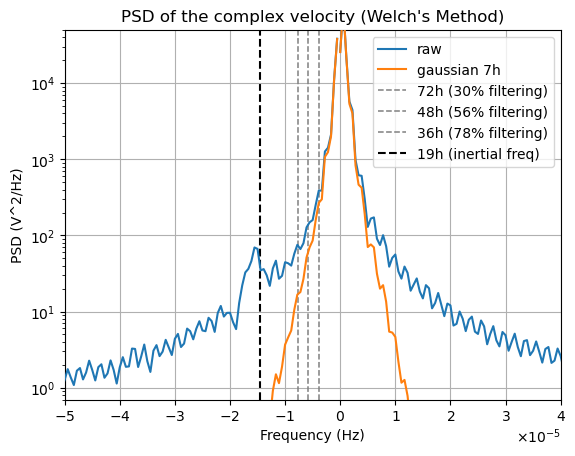

In [20]:
sig_raw = one_trajectory.lon.values+1j*one_trajectory.lat.values
sig_filtered = liss_lon+1j*liss_lat

matplotlib.rcParams['figure.dpi'] = 100
(freq0, psd0), (freq, psd) = utils_plots.welch([sig_raw, sig_filtered], ['raw', 'gaussian 7h'], float(one_trajectory.dt), [(72, '72h (30% filtering)', 'grey'),
                                                                                                    (48, '48h (56% filtering)', 'grey'),
                                                                                                    (36, '36h (78% filtering)', 'grey')
                                                                                                    ], 
                                                                                                    nfenetre=1000, save=True, save_path=path_save_plots)

ord = np.argsort(freq) 

freq = freq[ord]
psd = psd[ord]
psd0 = psd0[ord]

filter_fraction = psd/psd0

# filtering at 19h
print('filtering at 19h:', np.interp(1/(19*3600), freq, filter_fraction))
print('filtering at 24h:', np.interp(-1/(24*3600), freq, filter_fraction))
print('filtering at 36h:', np.interp(-1/(36*3600), freq, filter_fraction))
print('filtering at 48h:', np.interp(-1/(48*3600), freq, filter_fraction))
print('filtering at 72h:', np.interp(-1/(72*3600), freq, filter_fraction))
print('filtering at 96h:', np.interp(-1/(96*3600), freq, filter_fraction))
print('filtering at 120h:', np.interp(-1/(120*3600), freq, filter_fraction))